#**Primera entrega trabajo final**

Los retrasos en los vuelos son una situación frecuente que puede ocurrir por diveresas razones. Estos perjudican tanto al cliente, al generar contratiempos que afectan compromisos programados o conexiones con otros vuelos, así como también a las aerolíneas, que incurren en gastos extra por pedidos de reembolsos o compensaciones. Debido a esto es importante conocer qué factores influyen en los atrasos de salida de los vuelos y poder anticipar si alguno sufrirá alguna demora.

En este trabajo se utilizará una base de datos con información de vuelos de 2019 en Estados Unidos para intentar predecir si un vuelo se retrasará en función de distintas características, tanto del mismo vuelo, como del contexto en el cual está programado para salir.

**Base de datos:** https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/MyDrive/Data Science/Trabajo'
df = pd.read_csv('train.csv')
df.head()

/content/gdrive/MyDrive/Data Science/Trabajo


,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
0,7,7,0,1500-1559,3,3,26,160,American Airlines Inc.,19534,...,Chicago O'Hare International,0.00,0.0,0.0,95.0,4.25,0.237709,0.273236,0.222538,0.255479
1,4,1,0,1300-1359,4,4,63,50,SkyWest Airlines Inc.,18788,...,El Paso International,0.00,0.0,0.0,71.0,11.41,0.154651,0.121849,0.237972,0.197503
2,11,4,0,0001-0559,2,1,3,76,American Eagle Airlines Inc.,1148,...,NONE,0.00,0.0,0.0,54.0,0.45,0.117559,0.187867,0.139886,0.060327
3,3,2,0,1500-1559,7,5,14,143,Southwest Airlines Co.,7612,...,San Jose International,0.00,0.0,0.0,64.0,8.05,0.204389,0.141446,0.132868,0.202037
4,7,3,0,0800-0859,1,2,85,50,American Eagle Airlines Inc.,29376,...,Cincinnati/Northern Kentucky International,0.01,0.0,0.0,94.0,10.51,0.203263,0.193761,0.203027,0.113050


In [4]:
#Para una mejor interpretación y facilidad del manejo de datos renombraré las columnas y eliminaré las últimas 4, ya que no forman parte del dataset de test de modelo
df.columns

Index(['MONTH', 'DAY_OF_WEEK', 'DEP_DEL15', 'DEP_TIME_BLK', 'DISTANCE_GROUP',
       'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
       'CARRIER_NAME', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH',
       'AIRLINE_AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT',
       'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS',
       'GROUND_SERV_PER_PASS', 'PLANE_AGE', 'DEPARTING_AIRPORT', 'LATITUDE',
       'LONGITUDE', 'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND',
       'CARRIER_HISTORICAL', 'DEP_AIRPORT_HIST', 'DAY_HISTORICAL',
       'DEP_BLOCK_HIST'],
      dtype='object')

In [5]:
df.rename(columns={'MONTH':'mes','DAY_OF_WEEK':'dia','DEP_DEL15':'atraso','DEP_TIME_BLK':'depblock','DISTANCE_GROUP':'distancia',
       'SEGMENT_NUMBER':'segmento', 'CONCURRENT_FLIGHTS':'vuelos concurrentes', 'NUMBER_OF_SEATS':'asientos',
       'CARRIER_NAME':'aerol', 'AIRPORT_FLIGHTS_MONTH':'vuelos x aerop', 'AIRLINE_FLIGHTS_MONTH':'vuelos x aerol',
       'AIRLINE_AIRPORT_FLIGHTS_MONTH':'vuelos x aerop x aerol', 'AVG_MONTHLY_PASS_AIRPORT':'pasajeros x aerop',
       'AVG_MONTHLY_PASS_AIRLINE':'pasajeros x aerol', 'FLT_ATTENDANTS_PER_PASS':'aux x pasajero',
       'GROUND_SERV_PER_PASS':'servtierra x pasajero', 'PLANE_AGE':'avion antig', 'DEPARTING_AIRPORT':'aerop', 'LATITUDE':'latitud',
       'LONGITUDE':'longitud', 'PREVIOUS_AIRPORT':'aerop previo', 'PRCP':'precip', 'SNOW':'nieve', 'SNWD':'nieve acum', 'TMAX':'temp max',
        'AWND':'viento max'}, inplace=True)
df.drop(['CARRIER_HISTORICAL','DEP_AIRPORT_HIST','DAY_HISTORICAL','DEP_BLOCK_HIST'],axis=1,inplace=True)
df.columns

Index(['mes', 'dia', 'atraso', 'depblock', 'distancia', 'segmento',
       'vuelos concurrentes', 'asientos', 'aerol', 'vuelos x aerop',
       'vuelos x aerol', 'vuelos x aerop x aerol', 'pasajeros x aerop',
       'pasajeros x aerol', 'aux x pasajero', 'servtierra x pasajero',
       'avion antig', 'aerop', 'latitud', 'longitud', 'aerop previo', 'precip',
       'nieve', 'nieve acum', 'temp max', 'viento max'],
      dtype='object')

# **Descripción de las variables del dataset**:

(entre paréntesis el cambio de nombre)

• **MONTH (mes):** Mes

• **DAY_OF_WEEK (dia):** Día de la semana

• **DEP_DEL15 (atraso):** Binario si la salida se atrasa más de 15 minutos (1 es sí)

• **DEP_BLOCK (depblock):** Departure block. Rango horario del día en el que el vuelo está programado para salir. Formato: HHMM-HHMM

• **DISTANCE_GROUP (distancia):**	Grupo de distancia de vuelo desde el aeropuerto de salida

• **SEGMENT_NUMBER (segmento):**	Segmento del cronograma diario en el que el avión se encuentra

• **CONCURRENT_FLIGHTS (vuelos concurrentes):**	Vuelos previstos a salir en el mismo aeropuerto en el mismo departure block

• **NUMBER_OF_SEATS (asientos):** Número de asientos del avión

• **CARRIER_NAME (aerol):**	Aerolínea

• **AIRPORT_FLIGHTS_MONTH (vuelos x aerop):** Vuelos promedio por mes del aeropuerto

• **AIRLINE_FLIGHTS_MONTH (vuelos x aerol):** Vuelos promedio por mes de la aerolínea

• **AIRLINE_AIRPORT_FLIGHTS_MONTH (vuelos x aerop x aerol):** Vuelos promedio por mes por aerolínea y aeropuerto

• **AVG_MONTHLY_PASS_AIRPORT (pasajeros x aerop):** Promedio de pasajeros por mes del aeropuerto

• **AVG_MONTHLY_PASS_AIRLINE (pasajeros x aerol):**	Promedio de pasajeros por mes de la aerolínea

• **FLT_ATTENDANTS_PER_PASS (aux x pasajero):** Auxiliares de vuelo por pasajero por aerolinea

• **GROUND_SERV_PER_PASS (servtierra x pasajero):**	Empleados de servicio en tierra por pasajero por aerolínea

• **PLANE_AGE (avion antig):** Antigüedad del avión en años

• **DEPARTING_AIRPORT (aerop):** Aeropuerto de salida

• **LATITUDE (latitud):**	Latitud del aeropuerto de salida

• **LONGITUDE (longitud):** Longitud del aeropuerto de salida

• **PREVIOUS_AIRPORT (aerop previo):** Aeropuerto previo del que el avión salió

• **PRCP (precip):** Precipitación del día en pulgadas

• **SNOW (nieve):**	Precipitación de nieve del día en pulgadas

• **SNWD (nieve acum):**	Nieve acumulada en pulgadas

• **TMAX (temp max):**	Temperatura máxima del día en °F

• **AWND (viento max):**	Velocidad máxima del viento del día en mph

In [6]:
#Aquellas variables medidas en pulgadas, °F y mph se pasarán a cm, °C y km/h, respectivamente
df['precip'] = df['precip']*2.54
df['nieve'] = df['nieve']*2.54
df['nieve acum'] = df['nieve acum']*2.54
df['temp max'] = ((df['temp max'] - 32)*5)/9
df['viento max'] = df['viento max']*1.60934

In [7]:
df['depblock'] = df['depblock'].replace({'0001-0559':'5','0600-0659':'6','0700-0759':'7','0800-0859':'8','0900-0959':'9','1000-1059':'10',
                       '1100-1159':'11','1200-1259':'12','1300-1359':'13','1400-1459':'14','1500-1559':'15','1600-1659':'16',
                       '1700-1759':'17','1800-1859':'18','1900-1959':'19','2000-2059':'20','2100-2159':'21','2200-2259':'22',
                       '2300-2359':'23'})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4542343 entries, 0 to 4542342
Data columns (total 26 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   mes                     int64  
 1   dia                     int64  
 2   atraso                  int64  
 3   depblock                object 
 4   distancia               int64  
 5   segmento                int64  
 6   vuelos concurrentes     int64  
 7   asientos                int64  
 8   aerol                   object 
 9   vuelos x aerop          int64  
 10  vuelos x aerol          int64  
 11  vuelos x aerop x aerol  int64  
 12  pasajeros x aerop       int64  
 13  pasajeros x aerol       int64  
 14  aux x pasajero          float64
 15  servtierra x pasajero   float64
 16  avion antig             int64  
 17  aerop                   object 
 18  latitud                 float64
 19  longitud                float64
 20  aerop previo            object 
 21  precip                  float64

El dataframe contiene 4.542.343 filas y 26 columnas:

• 22 de valores numéricos (9 tipo float y 13 tipo entero)

• 4 de valores de cadena

In [9]:
dfna = df.isnull().sum()
dfna

,0
mes,0
dia,0
atraso,0
depblock,0
distancia,0
segmento,0
vuelos concurrentes,0
asientos,0
aerol,0
vuelos x aerop,0


Ninguna de las columnas cuenta con valores ausentes

In [10]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mes,4542343.0,NaN,NaN,NaN,6.607797,3.396624,1.0,4.0,7.0,10.0,12.0
dia,4542343.0,NaN,NaN,NaN,3.93649,1.995264,1.0,2.0,4.0,6.0,7.0
atraso,4542343.0,NaN,NaN,NaN,0.189144,0.391623,0.0,0.0,0.0,0.0,1.0
depblock,4542343,19,8,316638,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distancia,4542343.0,NaN,NaN,NaN,3.820224,2.381773,1.0,2.0,3.0,5.0,11.0
segmento,4542343.0,NaN,NaN,NaN,3.047252,1.758031,1.0,2.0,3.0,4.0,15.0
vuelos concurrentes,4542343.0,NaN,NaN,NaN,27.844608,21.514129,1.0,11.0,23.0,39.0,109.0
asientos,4542343.0,NaN,NaN,NaN,133.76058,46.474798,44.0,90.0,143.0,172.0,337.0
aerol,4542343,17,Southwest Airlines Co.,907076,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vuelos x aerop,4542343.0,NaN,NaN,NaN,12689.243436,8841.530836,1100.0,5345.0,11562.0,17615.0,35256.0


A partir de este resumen se puede observar que:

• El 18,9% de los vuelos sufren una demora mayor a 15 minutos.

• El rango horario en el que más se concentran los vuelos es entre las 8 y 9 de la mañana.

• El aeropuerto del que más vuelos despegan es el Atlanta Municipal y la aerolínea que concentra más vuelos es Southwest Airlines Co.

• Los aviones tienen una antigüedad promedio de 11,5 años y una capacidad promedio de casi 134 pasajeros

• Más del 50% de los vuelos han salido en días en los que no ha llovido y más del 75% de los vuelos han salido en días en los que no ha nevado ni había nieve acumulada de días anteriores.

---

En general, todas las variables muestran valores dentro de lo esperado y no se observan anomalías, con excepción de dos que llaman la atención:

• Máximo de 109 vuelos concuerrentes (con un tercer cuartil posicionado en 39)

• Mínimo de -23°C de la temperatura máxima (con un primer cuartil posicionado en 15°C)

---

A continuación las observamos en detalle:

[Text(0.5, 1.0, 'Distribución de la cantidad de vuelos concurrentes registrados'),
 Text(0.5, 0, 'Cantidad de vuelos concurrentes'),
 Text(0, 0.5, 'Distribución de observaciones')]

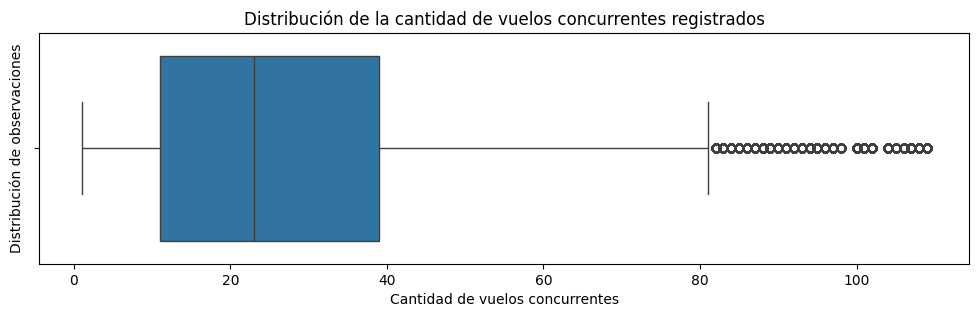

In [11]:
fig , ax = plt.subplots(figsize=(12,3))
sns.boxplot(x=df['vuelos concurrentes'],ax=ax).set(title='Distribución de la cantidad de vuelos concurrentes registrados',
                                             xlabel='Cantidad de vuelos concurrentes', ylabel='Distribución de observaciones')

Existen varios casos que superan el límite inlier de aprox 80 vuelos concurrentes. Teniendo en cuenta que los vuelos concurrentes se corresponden a los vuelos del mismo block group y que cada BG es de 1 hora, es probable que estas observaciones correspondan a aeropuertos grandes, los cuales manejan una gran cantidad de flujo de vuelos y pueden llegar a superar los 100 vuelos en una hora.

Para esto analizamos la distribución de los vuelos concurrentes para los aeropuertos más transitados:

[Text(0.5, 1.0, 'Distribución de la cantidad de vuelos concurrentes registrados'),
 Text(0, 0.5, 'Aeropuertos con una media de VC mayor a la media total'),
 Text(0.5, 0, 'Cantidad de vuelos concurrentes')]

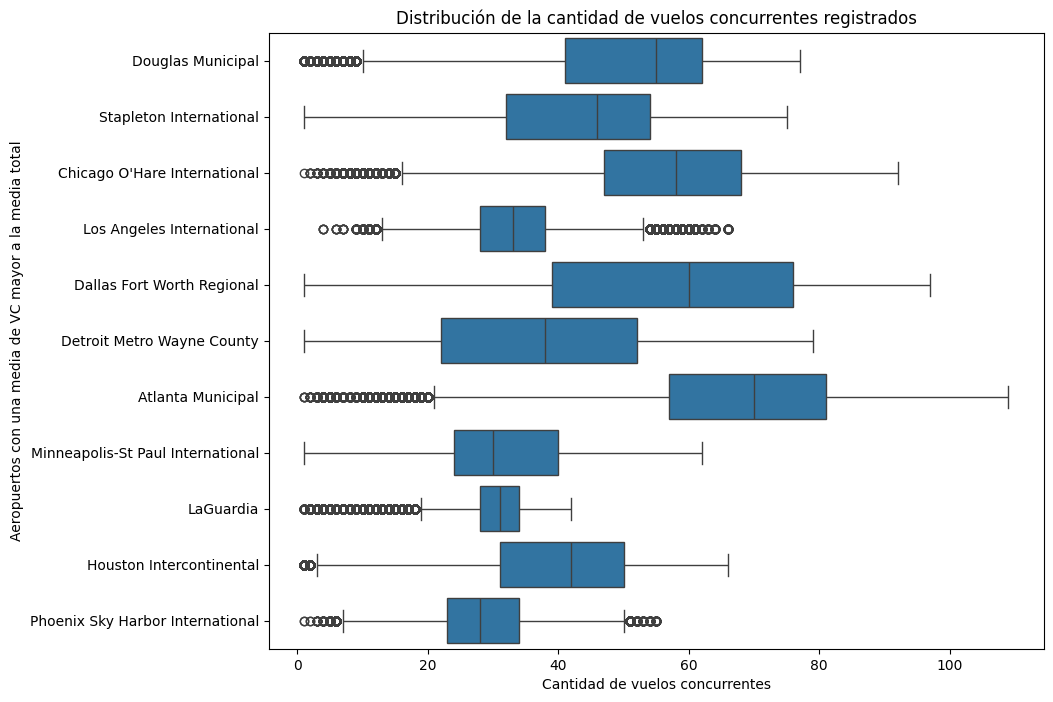

In [12]:
#Me quedo con los aeropuertos con una media de vuelos concurrentes mayor a la media general para ver la distribución en los aeropuertos mas transitados
vc_mean_aerop= df.groupby('aerop')['vuelos concurrentes'].mean()
vc_mean_aerop= vc_mean_aerop.reset_index()
vc_mean_aerop= vc_mean_aerop[vc_mean_aerop['vuelos concurrentes'] > df['vuelos concurrentes'].mean()]
aeropmax= pd.merge(df,vc_mean_aerop,on='aerop')

fig , ax = plt.subplots(figsize=(10,8))
sns.boxplot(x=aeropmax['vuelos concurrentes_x'], y=aeropmax['aerop'],ax=ax).set(title='Distribución de la cantidad de vuelos concurrentes registrados',
                                             ylabel='Aeropuertos con una media de VC mayor a la media total', xlabel='Cantidad de vuelos concurrentes')

Como se puede ver en la distribución de vuelos de los aeropuertos más concurridos, los valores de vuelos concurrentes mayores a 80 no se muestran como outliers. Los tres aeropuertos que superan esta cantidad de vuelos concurrentes (Chicago O'Hare International, Dallas Fort Worth Regional y Atlanta Municipal) tienen estas observaciones dentro de sus límites inliers. Atlanta Municipal es el aeropuerto al que le corresponden los valores de vuelos concurrentes más grandes, lo cual va en linea con la observación previa de que es también el que más registros concentra.

A partir de esto podemos concluir que los datos outliers observados en la variable de vuelos concurrentes presentan nueva información y no se tratan de errores

Text(0.5, 0, 'Distribución de observaciones')

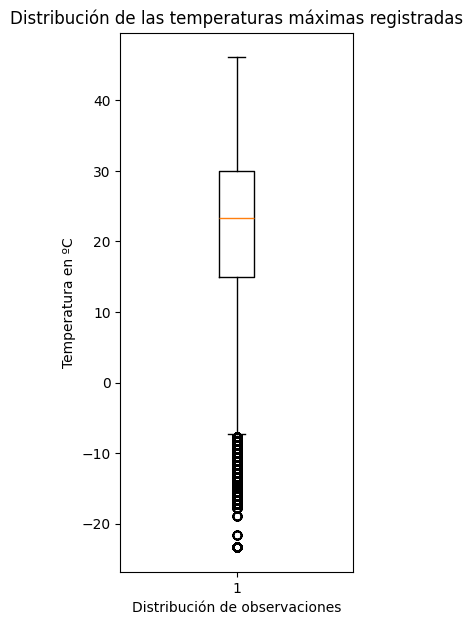

In [13]:
fig , ax = plt.subplots(figsize=(3,7))
ax.boxplot(df['temp max'])
ax.set_title('Distribución de las temperaturas máximas registradas')
ax.set_ylabel('Temperatura en ºC')
ax.set_xlabel('Distribución de observaciones')

Existen varias observaciones que se muestran como outliers y están por debajo de los 0°C. Veremos a continuación si los valores más extremos tienen sentido dada la ubicación del aeropuerto y el mes en el que ocurrieron

In [14]:
tempmin_aerop= df[df['temp max'] < -20]
tempmin_aerop = tempmin_aerop[['mes','atraso','aerop', 'temp max', 'latitud']]
tempmin_aerop= tempmin_aerop.drop_duplicates()
tempmin_aerop

,mes,atraso,aerop,temp max,latitud
7180,1,0,Chicago O'Hare International,-23.333333,41.978
7773,1,1,Chicago O'Hare International,-23.333333,41.978
66852,1,1,General Mitchell Field,-23.333333,42.950
84054,1,0,Des Moines Municipal,-21.666667,41.534
209804,1,0,Chicago Midway International,-23.333333,41.785
241935,1,1,Des Moines Municipal,-21.666667,41.534
253084,1,1,Chicago Midway International,-23.333333,41.785
432205,1,0,General Mitchell Field,-23.333333,42.950


Estas observaciones con valores extremos en la temperatura máxima ocurrieron en 4 aeropuertos que corresponden a las ciudades de Chicago, Milwaukee y Des Moines (Iowa), todos en el mes de enero.

En este mes en 2019 hubo una gran ola de frío polar que afectó particularmente a la zona de los grandes lagos y las llanuras cerca de la frontera con Canadá, que es donde se ubican estas ciudades.

https://www.weather.gov/fgf/2019_01_29-31_ExtremeCold

https://weather.com/storms/winter/news/2024-01-16-most-extreme-cold-outbreaks-us

A partir de esto podemos concluir que los datos outliers observados en la variable de vuelos concurrentes presentan nueva información y no se tratan de errores

---
---
#**Hipótesis:**


*   **H1:** las aerolineas lowcost tienden a tener mayor cantidad de vuelos atrasados

*   **H2:** las aerolineas con menos trabajadores en tierra por pasajero tienden a tener mayor cantidad de vuelos atrasados

*   **H3:** los vuelos programados a salir con una mayor cantidad de vuelos concurrentes tienden a atrasarse

*   **H4:** los vuelos de aerolineas con un mayor promedio de pasajeros mensuales tienden a atrasarse

---
**H1**

In [15]:
#Hay que definir cuáles son las aerolineas lowcost que aparecen en el df
df['aerol'].unique()

array(['American Airlines Inc.', 'SkyWest Airlines Inc.',
       'American Eagle Airlines Inc.', 'Southwest Airlines Co.',
       'JetBlue Airways', 'United Air Lines Inc.', 'Alaska Airlines Inc.',
       'Atlantic Southeast Airlines', 'Delta Air Lines Inc.',
       'Midwest Airline, Inc.', 'Comair Inc.', 'Endeavor Air Inc.',
       'Frontier Airlines Inc.', 'Spirit Air Lines', 'Mesa Airlines Inc.',
       'Allegiant Air', 'Hawaiian Airlines Inc.'], dtype=object)

Según la información disponible en internet, las aerolíneas de bajo coste del listado son las siguientes:

*   Southwest Airlines Co.
*   JetBlue Airways
*   Frontier Airlines Inc.
*   Spirit Air Lines
*   Allegiant Air

https://www.worldairlineawards.com/es/mejores-aerolineas-de-bajo-coste-del-mundo-2024/

https://www.aerolineaslowcost.com/lista-aerolineas-low-cost-pais/

https://es.wikipedia.org/wiki/Anexo:Aerol%C3%ADneas_de_bajo_costo

https://www.kayak.com.ar/travelawards/2020/best-airlines/best-budget/united-states/best-airline

In [16]:
#Creamos una nueva variable para identificar aquellas aerolineas lowcost (1 si es lowcost, 0 si no)
df.loc[(df['aerol']=='Southwest Airlines Co.') | (df['aerol']=='JetBlue Airways') | (df['aerol']=='Frontier Airlines Inc.') | (df['aerol']=='Spirit Air Lines') | (df['aerol']=='Allegiant Air'),'lowcost'] = 1
df.loc[df['lowcost'].isna(), 'lowcost']=0

In [17]:
lowcost0= df['lowcost']==0
lowcost1= df['lowcost']==1
atraso0= df['atraso']==0
atraso1= df['atraso']==1
matriz = pd.DataFrame([[(lowcost0 & atraso0).sum(), (lowcost0 & atraso1).sum()],
 [(lowcost1 & atraso0).sum(), (lowcost1 & atraso1).sum()]], index=['no lowcost', 'lowcost'],columns=['a horario', 'atrasado'])

In [18]:
print('Porcentaje de vuelos atrasados:', (df['atraso']==1).sum()/len(df)*100)
print('-'*100)
print(matriz)
print('-'*100)
print('Porcentaje de vuelos de aerolíneas lowcost con atraso:', (lowcost1 & atraso1).sum()/(lowcost1==1).sum()*100)
print('Porcentaje de vuelos de aerolíneas no lowcost con atraso:', (lowcost0 & atraso1).sum()/(lowcost0==1).sum()*100)

Porcentaje de vuelos atrasados: 18.914423679585624
----------------------------------------------------------------------------------------------------
            a horario  atrasado
no lowcost    2630615    568890
lowcost       1052570    290268
----------------------------------------------------------------------------------------------------
Porcentaje de vuelos de aerolíneas lowcost con atraso: 21.61601027078471
Porcentaje de vuelos de aerolíneas no lowcost con atraso: 17.78056293082836


Podemos ver que el porcentaje de vuelos atrasados es mayor en aerolíneas lowcost que en aquellas que no lo son, aunque la diferencia es de menos de un 4%.

---
**H2**

[Text(0.5, 0, 'Trabajadores en tierra por pasajero por aerolínea'),
 Text(0, 0.5, 'Proporción de atraso por aerolínea')]

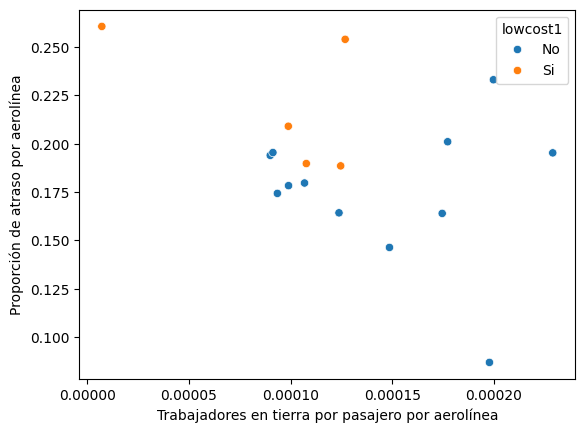

In [19]:
df.loc[df['lowcost']==1,'lowcost1']="Si"
df.loc[df['lowcost']==0,'lowcost1']="No"

#Cada aerolinea cuenta con un promedio de trabajadores en tierra por pasajero único
atraso_aerol = df.groupby('aerol')['atraso'].mean() #Agrupamos las aerolineas por el promedio de atraso que tienen
atraso_aerol= atraso_aerol.reset_index()
servtierra= df[['lowcost1','aerol','servtierra x pasajero']].drop_duplicates()
atraso_servtierra= pd.merge(atraso_aerol,servtierra,on='aerol')

sns.scatterplot(x=atraso_servtierra['servtierra x pasajero'], y=atraso_servtierra['atraso'],
                hue=atraso_servtierra['lowcost1']).set(xlabel='Trabajadores en tierra por pasajero por aerolínea',
                                                              ylabel='Proporción de atraso por aerolínea')

La dispersión de los puntos en el gráfico parece existir una leve correlación lineal de pendiente negativa (a mayor promedio de trabajadores en tierra, menos vuelos atrasados), que iría en línea con H2. Sin embargo, existen varios outliers: aunque no se observan aerolíneas con un bajo promedio de trabajadores en tierra por pasajero que tengan una baja proporción de atraso, sí se observan aerolíneas con un alto promedio de trabajadores en tierra por pasajero que tienen una proporción de atrasos alta. En cualquier caso, esto último puede deberse a otros factores.

Es de destacar también que, en línea con lo observado en #H1, se hace más evidente que las aerolíneas lowcost (en naranja) tienden a tener una proporción de atraso mayor que las que no lo son.

---
**H3**

Text(0.5, 0, 'Vuelos concurrentes')

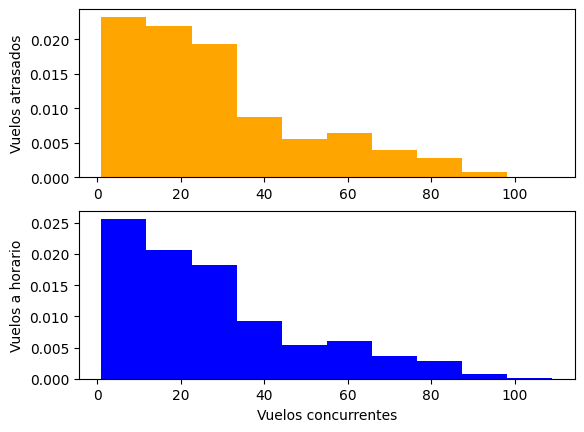

In [20]:
atraso1 = df[df['atraso']==1]
atraso0 = df[df['atraso']==0]

fig, ax = plt.subplots(2,1)
ax[0].hist(atraso1['vuelos concurrentes'], color='orange', density=True)
ax[1].hist(atraso0['vuelos concurrentes'], color='blue', density=True)
ax[0].set_ylabel('Vuelos atrasados')
ax[1].set_ylabel('Vuelos a horario')
ax[1].set_xlabel('Vuelos concurrentes')

No parece existir una relación entre la cantidad de vuelos concurrentes y el atraso de un vuelo. A pesar de que existe una mayor densidad de vuelos atrasados entre los 10 y los 30 vuelos concurrentes, en comparación con los no atrasados, no se obsrevan mayor densidad de vuelos atrasados a medida que aumenta la cantidad de vuelos concurrentes en comparación con los no atrasados.

---
**H4**

Text(0.5, 0, 'Vuelo atrasado')

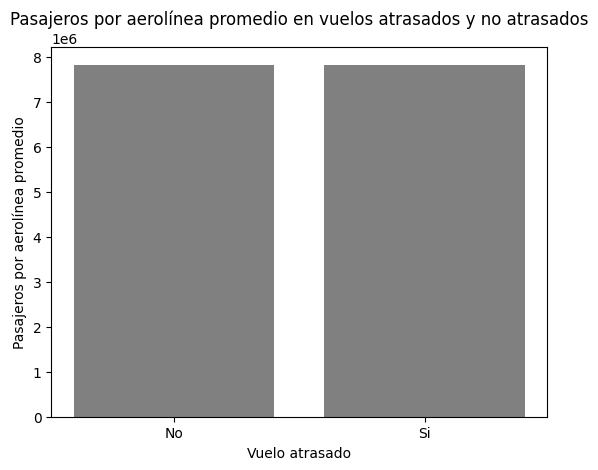

In [21]:
df.loc[df['atraso']==1,'atraso1']="Si"
df.loc[df['atraso']==0,'atraso1']="No"
atraso_pasajxaerol= df.groupby('atraso1')['pasajeros x aerol'].mean()
atraso_pasajxaerol= atraso_pasajxaerol.reset_index()

fig , ax = plt.subplots()
ax.bar(atraso_pasajxaerol['atraso1'],atraso_pasajxaerol['pasajeros x aerol'],color='grey')
ax.set_title('Pasajeros por aerolínea promedio en vuelos atrasados y no atrasados')
ax.set_ylabel('Pasajeros por aerolínea promedio')
ax.set_xlabel('Vuelo atrasado')

Según el gráfico parece no haber una relación entre las variables de promedio pasajeros mensuales por aerolínea y atraso en los vuelos. Se puede ver que tanto los vuelos atrasados como los que salen a horario tienen un promedio de pasajeros mensuales promedio por aerolínea de casi 8 millones y no se observan diferencias significativas

---
A pesar de que es sabido que las condiciones climáticas extremas tienden a atrasar los vuelos y no se haya planteado como hipótesis, veremos también como se relacionan las variables climáticas del df con la de atraso para corroborar que dicha relación vaya en línea con lo esperado.

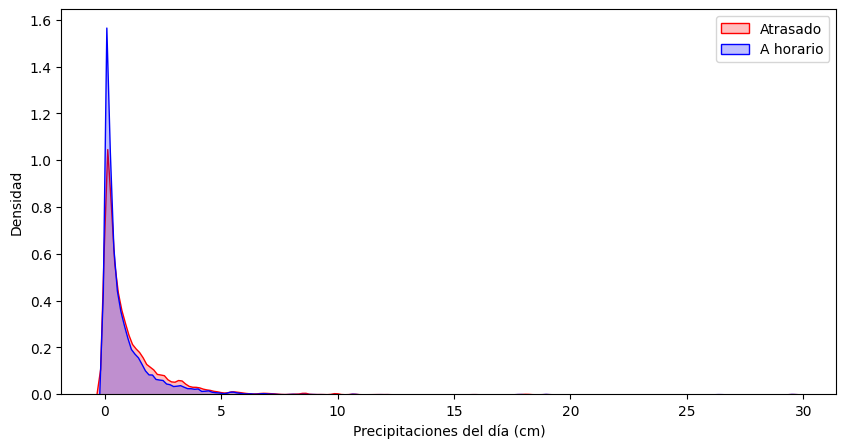

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=df.loc[(df['atraso']==1) & (df['precip'] > 0), 'precip'],
            color='red', label='Atrasado', fill=True, ax=ax)
sns.kdeplot(data=df.loc[(df['atraso']==0) & (df['precip'] > 0), 'precip'],
            color='blue', label='A horario', fill=True, ax=ax)
ax.set_ylabel('Densidad')
ax.set_xlabel('Precipitaciones del día (cm)')
ax.legend()
plt.show()
#Miramos los valores mayores a 0 debido a que, como se vio, más del 50% de las observaciones adoptaban ese valor...
#..y nos impediría ver en el gráfico el efecto de la variable cuando aumenta

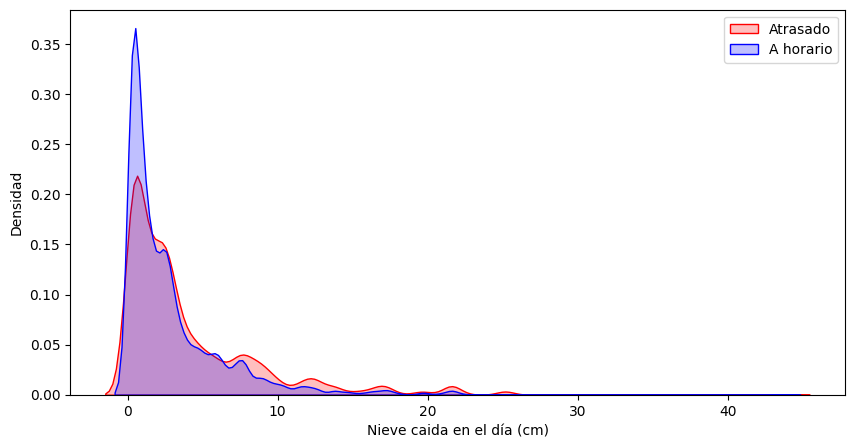

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=df.loc[(df['atraso']==1) & (df['nieve'] > 0), 'nieve'],
            color='red', label='Atrasado', fill=True, ax=ax)
sns.kdeplot(data=df.loc[(df['atraso']==0) & (df['nieve'] > 0), 'nieve'],
            color='blue', label='A horario', fill=True, ax=ax)
ax.set_ylabel('Densidad')
ax.set_xlabel('Nieve caida en el día (cm)')
ax.legend()
plt.show()
#Miramos los valores mayores a 0 debido a que, como se vio, más del 75% de las observaciones adoptan ese valor...
#..y nos impediría ver en el gráfico el efecto de la variable cuando aumenta

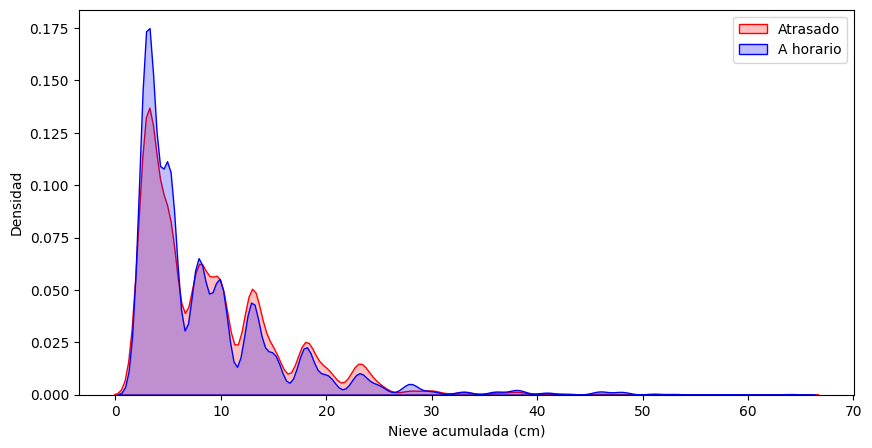

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=df.loc[(df['atraso']==1) & (df['nieve acum'] > 0), 'nieve acum'],
            color='red', label='Atrasado', fill=True, ax=ax)
sns.kdeplot(data=df.loc[(df['atraso']==0) & (df['nieve acum'] > 0), 'nieve acum'],
            color='blue', label='A horario', fill=True, ax=ax)
ax.set_ylabel('Densidad')
ax.set_xlabel('Nieve acumulada (cm)')
ax.legend()
plt.show()
#Miramos los valores mayores a 0 debido a que, como se vio, más del 75% de las observaciones adoptan ese valor...
#..y nos impediría ver en el gráfico el efecto de la variable cuando aumenta

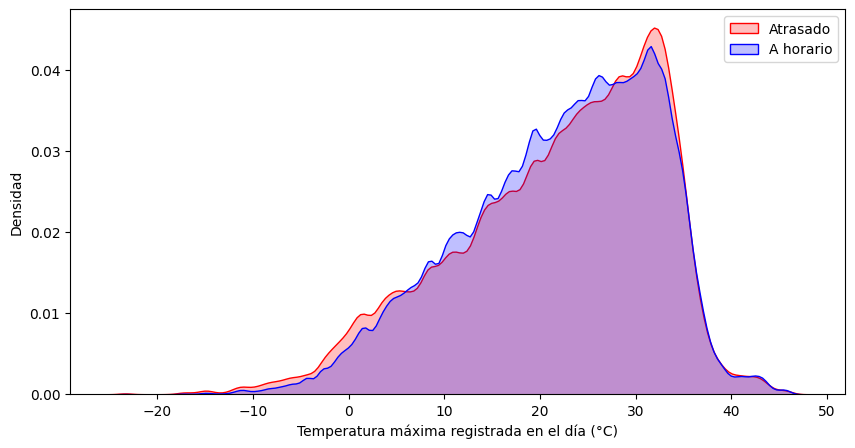

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=df.loc[(df['atraso']==1), 'temp max'],
            color='red', label='Atrasado', fill=True, ax=ax)
sns.kdeplot(data=df.loc[(df['atraso']==0), 'temp max'],
            color='blue', label='A horario', fill=True, ax=ax)
ax.set_ylabel('Densidad')
ax.set_xlabel('Temperatura máxima registrada en el día (°C)')
ax.legend()
plt.show()

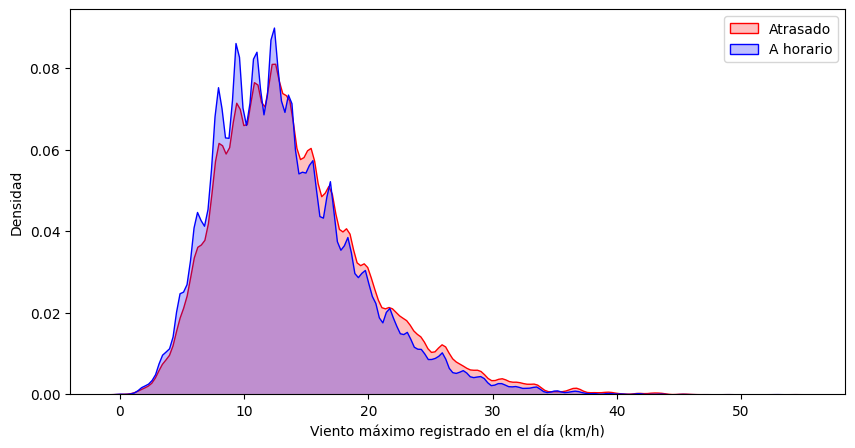

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(data=df.loc[(df['atraso']==1), 'viento max'],
            color='red', label='Atrasado', fill=True, ax=ax)
sns.kdeplot(data=df.loc[(df['atraso']==0), 'viento max'],
            color='blue', label='A horario', fill=True, ax=ax)
ax.set_ylabel('Densidad')
ax.set_xlabel('Viento máximo registrado en el día (km/h)')
ax.legend()
plt.show()

Como se puede ver en los gráficos, la densidad de vuelos atrasados es mayor en comparación con los no atrasados cuando las condiciones climáticas se vuelven más extremas.

En los casos de las precipitaciones, la nieve caída, la nieve acumulada y el viento máximo, la densidad de los vuelos atrasados aumenta en comparación con los vuelos no atrasados cuando los valores se alejan de 0. En el caso de la temperatura máxima se observa que la densidad de los vuelos atrasados es mayor en aquellos valores de temperaturas más extremas (menor a 5°C y mayor a 30°C, aproximadamente).

----------------------
Verificación de correlación con otras variables:

Text(0.5, 0, 'Vuelo atrasado')

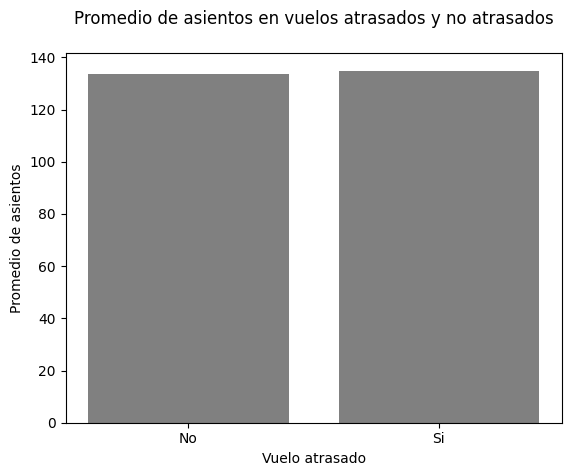

In [27]:
atraso_asientos= df.groupby('atraso1')['asientos'].mean()
atraso_asientos= atraso_asientos.reset_index()

fig , ax = plt.subplots()
ax.bar(atraso_asientos['atraso1'],atraso_asientos['asientos'],color='grey')
ax.set_title('Promedio de asientos en vuelos atrasados y no atrasados\n')
ax.set_ylabel('Promedio de asientos')
ax.set_xlabel('Vuelo atrasado')

Text(0.5, 0, 'Vuelo atrasado')

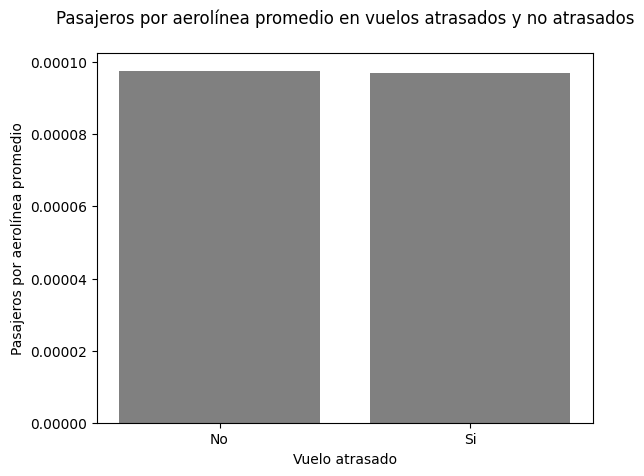

In [28]:
atraso_aux= df.groupby('atraso1')['aux x pasajero'].mean()
atraso_aux= atraso_aux.reset_index()

fig , ax = plt.subplots()
ax.bar(atraso_aux['atraso1'],atraso_aux['aux x pasajero'],color='grey')
ax.set_title('Pasajeros por aerolínea promedio en vuelos atrasados y no atrasados\n')
ax.set_ylabel('Pasajeros por aerolínea promedio')
ax.set_xlabel('Vuelo atrasado')

Text(0.5, 0, 'Vuelo atrasado')

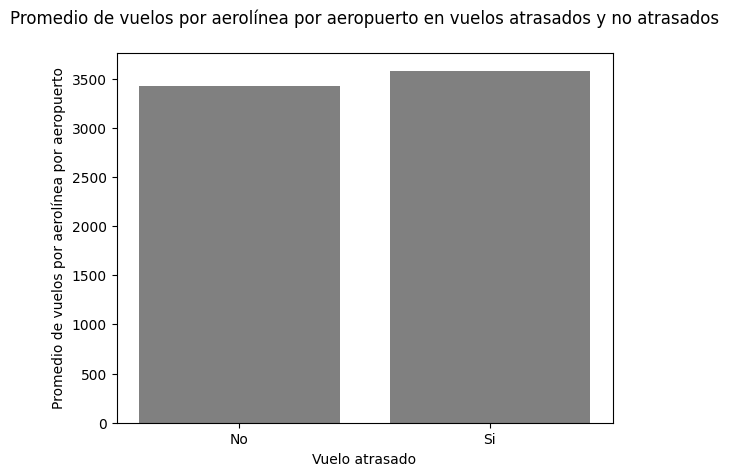

In [29]:
atraso_vueloxaeropxaerol= df.groupby('atraso1')['vuelos x aerop x aerol'].mean()
atraso_vueloxaeropxaerol= atraso_vueloxaeropxaerol.reset_index()

fig , ax = plt.subplots()
ax.bar(atraso_vueloxaeropxaerol['atraso1'],atraso_vueloxaeropxaerol['vuelos x aerop x aerol'],color='grey')
ax.set_title('Promedio de vuelos por aerolínea por aeropuerto en vuelos atrasados y no atrasados\n')
ax.set_ylabel('Promedio de vuelos por aerolínea por aeropuerto')
ax.set_xlabel('Vuelo atrasado')

Se observa una leve correlación en el que aquellas aerolieas con un mayor promedio de vuelos por aeropuerto tienden a tener vuelos atrasados

Text(0.5, 0, 'Vuelo atrasado')

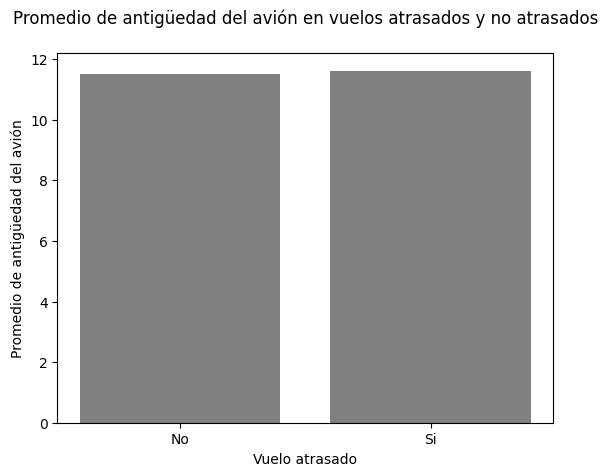

In [30]:
atraso_antig= df.groupby('atraso1')['avion antig'].mean()
atraso_antig= atraso_antig.reset_index()

fig , ax = plt.subplots()
ax.bar(atraso_antig['atraso1'],atraso_antig['avion antig'],color='grey')
ax.set_title('Promedio de antigüedad del avión en vuelos atrasados y no atrasados\n')
ax.set_ylabel('Promedio de antigüedad del avión')
ax.set_xlabel('Vuelo atrasado')

Text(0.5, 0, 'Vuelo atrasado')

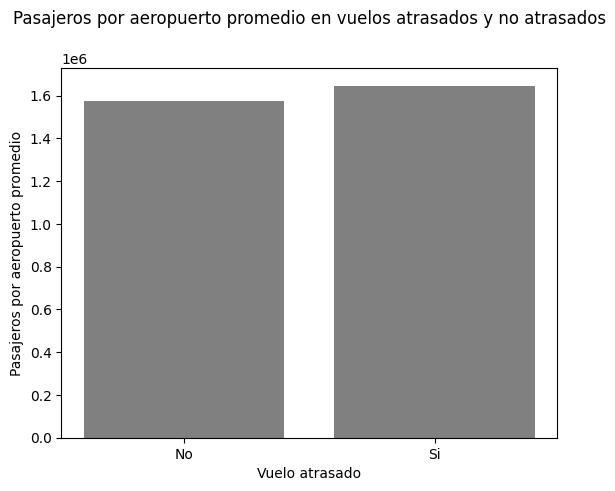

In [31]:
atraso_pasajxaerop= df.groupby('atraso1')['pasajeros x aerop'].mean()
atraso_pasajxaerop= atraso_pasajxaerop.reset_index()

fig , ax = plt.subplots()
ax.bar(atraso_pasajxaerop['atraso1'],atraso_pasajxaerop['pasajeros x aerop'],color='grey')
ax.set_title('Pasajeros por aeropuerto promedio en vuelos atrasados y no atrasados\n')
ax.set_ylabel('Pasajeros por aeropuerto promedio')
ax.set_xlabel('Vuelo atrasado')

Se observa una leve correlación en el que aquellas aeropuertos con un mayor promedio de pasajeros tienden a tener vuelos atrasados

Text(0.5, 0, 'Mes')

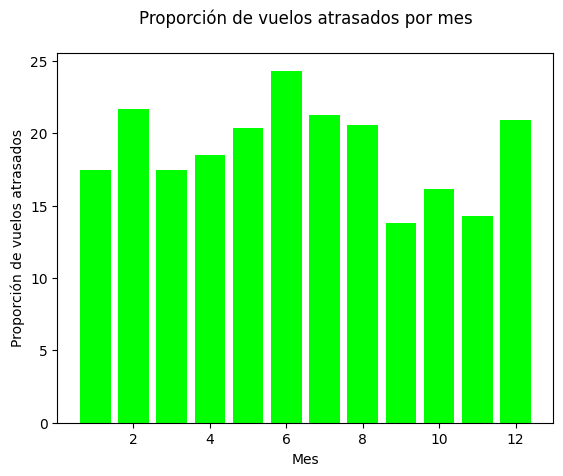

In [32]:
vuelosxmes= df.groupby('mes')['atraso'].count()
atrasoxmes= df.groupby('mes')['atraso'].sum()
vuelosxmes= vuelosxmes.reset_index()
atrasoxmes= atrasoxmes.reset_index()
meses= pd.merge(vuelosxmes,atrasoxmes,on='mes')

meses['porcentaje']= (meses['atraso_y']/meses['atraso_x'])*100
meses

fig, ax= plt.subplots()
ax.bar(meses['mes'],meses['porcentaje'],color='lime')
ax.set_title('Proporción de vuelos atrasados por mes\n')
ax.set_ylabel('Proporción de vuelos atrasados')
ax.set_xlabel('Mes')

Text(0.5, 0, 'Aeropuerto')

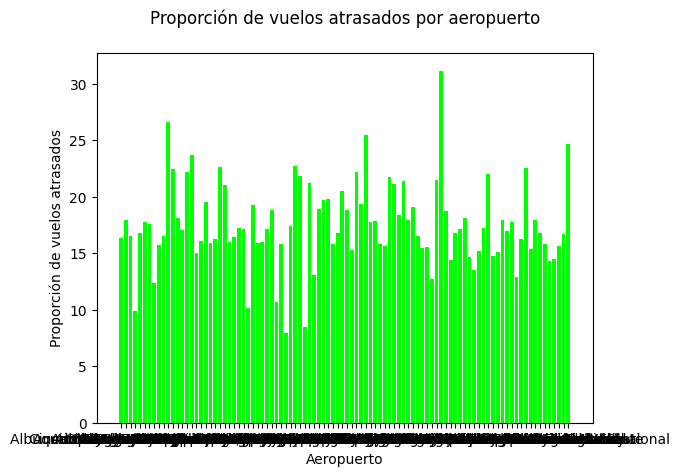

In [33]:
vuelosxaerop= df.groupby('aerop')['atraso'].count()
atrasoxaerop= df.groupby('aerop')['atraso'].sum()
vuelosxaerop= vuelosxaerop.reset_index()
atrasoxaerop= atrasoxaerop.reset_index()
aerop= pd.merge(vuelosxaerop,atrasoxaerop,on='aerop')

aerop['porcentaje']= (aerop['atraso_y']/aerop['atraso_x'])*100

fig, ax= plt.subplots()
ax.bar(aerop['aerop'],aerop['porcentaje'],color='lime')
ax.set_title('Proporción de vuelos atrasados por aeropuerto\n')
ax.set_ylabel('Proporción de vuelos atrasados')
ax.set_xlabel('Aeropuerto')

Text(0.5, 0, 'Rango horario')

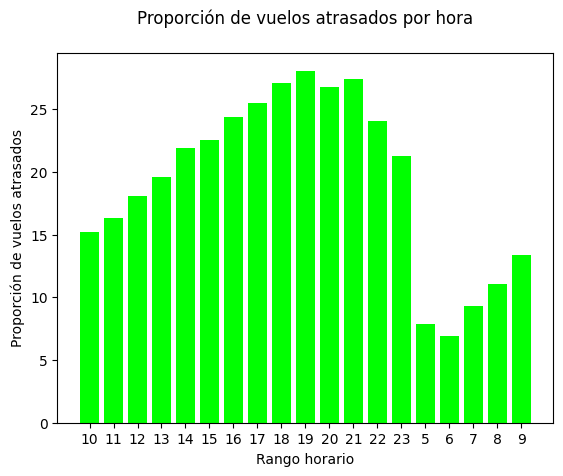

In [34]:
vuelosxdb= df.groupby('depblock')['atraso'].count()
atrasoxdb= df.groupby('depblock')['atraso'].sum()
vuelosxdb= vuelosxdb.reset_index()
atrasoxdb= atrasoxdb.reset_index()
depblock= pd.merge(vuelosxdb,atrasoxdb,on='depblock')

depblock['porcentaje']= (depblock['atraso_y']/depblock['atraso_x'])*100

fig, ax= plt.subplots()
ax.bar(depblock['depblock'],depblock['porcentaje'],color='lime')
ax.set_title('Proporción de vuelos atrasados por hora\n')
ax.set_ylabel('Proporción de vuelos atrasados')
ax.set_xlabel('Rango horario')

Se observa correlación en la que la cantidad de vuelos atrasados aumenta a medida que pasan las horas del día, con un pico en, aproximadamanete, las 19h, cuando empieza a decrecer

Text(0.5, 0, 'Día')

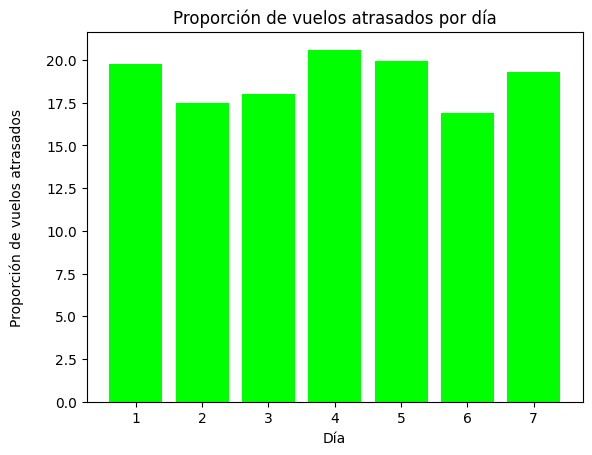

In [35]:
vuelosxdia= df.groupby('dia')['atraso'].count()
atrasoxdia= df.groupby('dia')['atraso'].sum()
vuelosxdia= vuelosxdia.reset_index()
atrasoxdia= atrasoxdia.reset_index()
dia= pd.merge(vuelosxdia,atrasoxdia,on='dia')

dia['porcentaje']= (dia['atraso_y']/dia['atraso_x'])*100

fig, ax= plt.subplots()
ax.bar(dia['dia'],dia['porcentaje'],color='lime')
ax.set_title('Proporción de vuelos atrasados por día')
ax.set_ylabel('Proporción de vuelos atrasados\n')
ax.set_xlabel('Día')

Text(0.5, 0, 'Segmento')

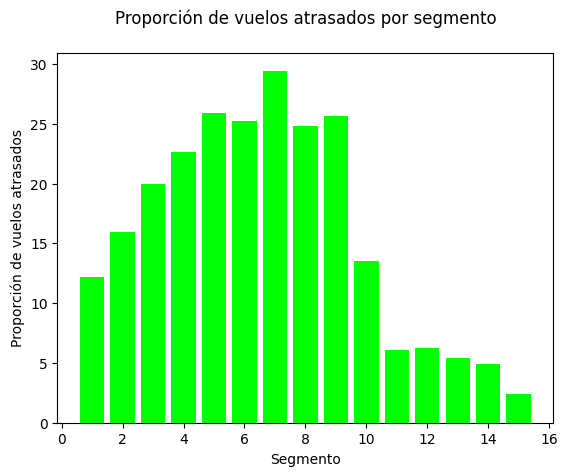

In [36]:
vuelosxsegmento= df.groupby('segmento')['atraso'].count()
atrasoxsegmento= df.groupby('segmento')['atraso'].sum()
vuelosxsegmento= vuelosxsegmento.reset_index()
atrasoxsegmento= atrasoxsegmento.reset_index()
segmento= pd.merge(vuelosxsegmento,atrasoxsegmento,on='segmento')

segmento['porcentaje']= (segmento['atraso_y']/segmento['atraso_x'])*100

fig, ax= plt.subplots()
ax.bar(segmento['segmento'],segmento['porcentaje'],color='lime')
ax.set_title('Proporción de vuelos atrasados por segmento\n')
ax.set_ylabel('Proporción de vuelos atrasados')
ax.set_xlabel('Segmento')

Se observa una mayor proporción de vuelos atrasados en los segmentos menores al décimo

------------
------------
# PARTE 2
------------
----------


In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [38]:
df= df.drop(['distancia','vuelos concurrentes','asientos','aux x pasajero','avion antig','vuelos x aerol',
             'aerol','aerop','vuelos x aerop','pasajeros x aerol','nieve','latitud','longitud','aerop previo',
             'lowcost1','atraso1'],axis=1)
df.columns

Index(['mes', 'dia', 'atraso', 'depblock', 'segmento',
       'vuelos x aerop x aerol', 'pasajeros x aerop', 'servtierra x pasajero',
       'precip', 'nieve acum', 'temp max', 'viento max', 'lowcost'],
      dtype='object')

In [39]:
X= df.drop('atraso',axis=1)
y= df['atraso']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [40]:
modelo= DecisionTreeClassifier(random_state=1234) #la etiqueta es binaria (atraso=1, no atraso=0), por lo tanto utilizo un modelo de clasificación
modelo.fit(X_train, y_train)
predicc= modelo.predict(X_test)

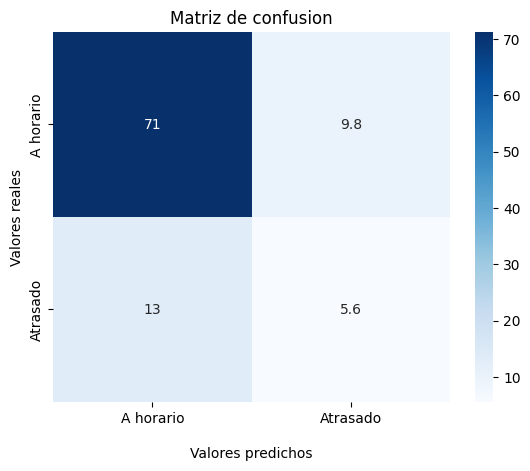

In [41]:
cm = confusion_matrix(y_test, predicc)
total = cm.sum()
cm_porcentaje = cm/total*100 #paso a pocentaje porque al ser millones de instancias la matriz de confusión muestra las cantidades en notación científica

ax = sns.heatmap(cm_porcentaje, annot=True, cmap='Blues')
ax.set_title('Matriz de confusion');
ax.set_xlabel('\nValores predichos')
ax.set_ylabel('Valores reales');
ax.xaxis.set_ticklabels(['A horario','Atrasado'])
ax.yaxis.set_ticklabels(['A horario','Atrasado'])
plt.show()

El modelo generado tiende a predecir correctamente aquellos vuelos que salen a horario pero no los que se atrasan. De hecho, cuenta con un sesgo muy grande en el cual tiende a sobreestimar la cantidad de vuelos a horario. Si se comparan los valores reales atrasados se ve que la gran mayoría fueron predichos incorrectamente, y esto también sucede con los vuelos a horario. Aunque en principio esto último no parecería presentar un problema, ya que la mayoría está siendo predicha de manera correcta, más de un 10% del total de los vuelos a horarios tampoco lo predice bien.

Por estas razones, no cosidero que el modelo sea apropiado para poder predecir si un vuelo estará atrasado o no, dadas las características del vuelo y su contexto. Algunas acciones que podrían mejorar los resultados pueden ser redefinir las features incluidas en el modelo como X y también testear otras posibilidades de modelos de clasificación, como la regresión logística.